In [8]:
import pandas as pd
import folium
from folium.plugins import HeatMap

nypd_data_cleaned = pd.read_csv("/Users/shashankhmg/Documents/AXA-Casestudy/Data-Science-Challenge/data/processed/nypd_data_cleaned.csv")

citibike_stations = pd.read_csv("/Users/shashankhmg/Documents/AXA-Casestudy/Data-Science-Challenge/data/processed/cleaned_citibike_data.csv")


/var/folders/tw/yc01l_99601d14ks8nxwg1dr0000gn/T/ipykernel_89665/2503581617.py:7: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  citibike_stations = pd.read_csv("/Users/shashankhmg/Documents/AXA-Casestudy/Data-Science-Challenge/data/processed/cleaned_citibike_data.csv")


In [2]:
nypd_data_cleaned.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,...,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2
0,11/01/2023,1:29,BROOKLYN,11230.0,40.621790,-73.970024,"(40.62179, -73.970024)",OCEAN PARKWAY,1.0,0.0,...,0,0,0,1,0,Unspecified,Unspecified,4675373,Moped,Sedan
1,09/11/2021,9:35,BROOKLYN,11208.0,40.667202,-73.866500,"(40.667202, -73.8665)",Unknown,0.0,0.0,...,0,0,0,0,0,Unspecified,Unknown,4456314,Sedan,Unknown
2,12/14/2021,8:13,BROOKLYN,11233.0,40.683304,-73.917274,"(40.683304, -73.917274)",SARATOGA AVENUE,0.0,0.0,...,0,0,0,0,0,Unknown,Unknown,4486609,Unknown,Unknown
3,12/14/2021,8:17,BRONX,10475.0,40.868160,-73.831480,"(40.86816, -73.83148)",Unknown,2.0,0.0,...,0,0,0,2,0,Unspecified,Unspecified,4486660,Sedan,Sedan
4,12/14/2021,21:10,BROOKLYN,11207.0,40.671720,-73.897100,"(40.67172, -73.8971)",Unknown,0.0,0.0,...,0,0,0,0,0,Driver Inexperience,Unspecified,4487074,Sedan,Unknown


In [3]:
citibike_stations.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,56BD148A05E26915,electric_bike,2025-01-01 22:19:06.324,2025-01-01 22:23:32.899,W 36 St & 7 Ave,6483.06,W 24 St & 7 Ave,6257.03,40.752149,-73.989539,40.744876,-73.995299,member
1,700CCCDF00C08077,electric_bike,2025-01-09 15:20:43.991,2025-01-09 15:26:19.137,Broadway & E 19 St,5980.11,W 24 St & 7 Ave,6257.03,40.738290,-73.990060,40.744876,-73.995299,member
2,B1A3FAFA5FE651CE,electric_bike,2025-01-01 12:54:26.571,2025-01-01 13:03:03.565,Jackson Ave & 46 Rd,6203.02,Crescent St & Broadway,6827.11,40.745248,-73.947333,40.763359,-73.928647,member
3,9CB0F28054BA5EBC,electric_bike,2025-01-14 13:43:59.151,2025-01-14 13:49:04.543,Broadway & E 19 St,5980.11,W 24 St & 7 Ave,6257.03,40.738290,-73.990060,40.744876,-73.995299,member
4,A1B8FDD4FAF0C2B2,electric_bike,2025-01-13 07:20:37.176,2025-01-13 07:29:18.015,Willis Ave & E 143 St,7798.02,1 Ave & E 110 St,7522.02,40.812299,-73.920370,40.792327,-73.938300,member


In [6]:
# Group by start station ID to compute average lat/lng per station
station_locations = citibike_stations.groupby(['start_station_id', 'start_station_name'])[['start_lat', 'start_lng']].mean().reset_index()

# Save station locations for future use
station_locations.to_csv("/Users/shashankhmg/Documents/AXA-Casestudy/Data-Science-Challenge/data/processed/citibike_station_locations.csv", index=False)


In [7]:
# Reduce dataset size: Focus only on past 3 months of accidents
nypd_data_cleaned['CRASH DATE'] = pd.to_datetime(nypd_data_cleaned['CRASH DATE'])
recent_accidents = nypd_data_cleaned[nypd_data_cleaned['CRASH DATE'] >= '2024-10-01']

# Filter for CitiBike-related accidents (cyclist injuries)
cyclist_accidents = recent_accidents[
    (recent_accidents['NUMBER OF CYCLIST INJURED'] > 0) | 
    (recent_accidents['NUMBER OF CYCLIST KILLED'] > 0)
]

# Extract accident locations (dropping missing values)
heatmap_data = cyclist_accidents[['LATITUDE', 'LONGITUDE']].dropna().values.tolist()

# Reduce CitiBike station markers (only show top 50 busiest stations)
top_stations = citibike_stations.head(50)

# Create base map centered on NYC
nyc_map = folium.Map(location=[40.75, -73.98], zoom_start=12)

# Faster Heatmap rendering (Lower radius & blur values)
HeatMap(heatmap_data, radius=7, blur=5, max_zoom=1).add_to(nyc_map)

# Use `itertuples()` for faster iteration of CitiBike stations
for row in top_stations.itertuples():
    folium.CircleMarker(
        location=[row.start_lat, row.start_lng],
        radius=3,
        color="red",
        fill=True,
        fill_color="red",
        fill_opacity=0.7,
        popup=f"Station: {row.start_station_name}"
    ).add_to(nyc_map)

#  Save the optimized heatmap
nyc_map.save("/Users/shashankhmg/Documents/AXA-Casestudy/Data-Science-Challenge/heatmaps/optimized_citibike_accident_heatmap.html")

# Identify the 10 Most Dangerous CitiBike Stations

In [ ]:
#Merge CitiBike station data with NYPD accident data
#Find accidents that happened near CitiBike stations (within 100 meters).
#Count accidents per CitiBike station
#Rank stations by the number of nearby accidents

In [19]:
import numpy as np
from scipy.spatial import cKDTree

# Create a dictionary to store accident counts per station
station_accident_dict = {}

# Filter only cyclist-related accidents
nypd_accidents = nypd_data_cleaned[
    (nypd_data_cleaned["NUMBER OF CYCLIST INJURED"] > 0) | 
    (nypd_data_cleaned["NUMBER OF CYCLIST KILLED"] > 0)
]

# Convert coordinates to numpy arrays for KDTree
accident_coords = np.array(list(zip(nypd_accidents["LATITUDE"], nypd_accidents["LONGITUDE"])))
station_coords = np.array(list(zip(citibike_stations["start_lat"], citibike_stations["start_lng"])))

# Build a cDTree for fast nearest neighbor search
#The cKDTree from scipy.spatial is a fast spatial data structure used to find the nearest neighbors efficiently.
accident_tree = cKDTree(accident_coords)
search_radius = 0.001

# Iterate over each CitiBike station
for index, row in citibike_stations.iterrows():
    station_id = row["start_station_id"]
    station_name = row["start_station_name"]
    
    # Count the number of accidents near this station
    accident_count = len(accident_tree.query_ball_point((row["start_lat"], row["start_lng"]), search_radius))
    
    # Store in dictionary
    if station_name in station_accident_dict:
        station_accident_dict[station_name] += accident_count
    else:
        station_accident_dict[station_name] = accident_count

# Convert dictionary to DataFrame
station_accident_df = pd.DataFrame(list(station_accident_dict.items()), columns=["start_station_name", "accident_count"])

# Get the top 10 most dangerous CitiBike stations
top_10_dangerous_stations = station_accident_df.nlargest(10, "accident_count")


In [20]:
top_10_dangerous_stations

,start_station_name,accident_count
1817,W 21 St & 6 Ave,419663
775,Forsyth St & Grand St,239112
1747,Broadway & E 14 St,211872
328,Broadway & W 58 St,183566
1754,6 Ave & W 33 St,179017
320,E 14 St & 1 Ave,178835
18,E 1 St & 1 Ave,175294
154,W 41 St & 8 Ave,166286
103,E 2 St & Ave A,158608
855,W 24 St & 7 Ave,157440


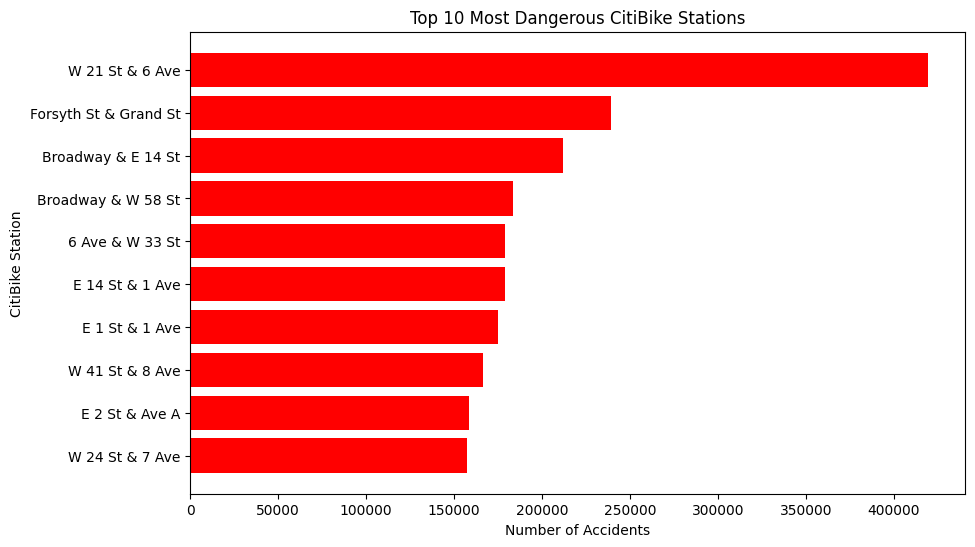

In [21]:
import matplotlib.pyplot as plt

# Plot Top 10 Most Dangerous CitiBike Stations as a Bar Chart
plt.figure(figsize=(10, 6))
plt.barh(top_10_dangerous_stations["start_station_name"], top_10_dangerous_stations["accident_count"], color='red')
plt.xlabel("Number of Accidents")
plt.ylabel("CitiBike Station")
plt.title("Top 10 Most Dangerous CitiBike Stations")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

/var/folders/tw/yc01l_99601d14ks8nxwg1dr0000gn/T/ipykernel_89665/2721334147.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nypd_accidents["CRASH DATE"] = pd.to_datetime(nypd_accidents["CRASH DATE"])
/var/folders/tw/yc01l_99601d14ks8nxwg1dr0000gn/T/ipykernel_89665/2721334147.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nypd_accidents["CRASH HOUR"] = pd.to_datetime(nypd_accidents["CRASH TIME"], format="%H:%M").dt.hour
/var/folders/tw/yc01l_99601d14ks8nxwg1dr0000gn/T/ipykernel_89665/2721334147.py:6

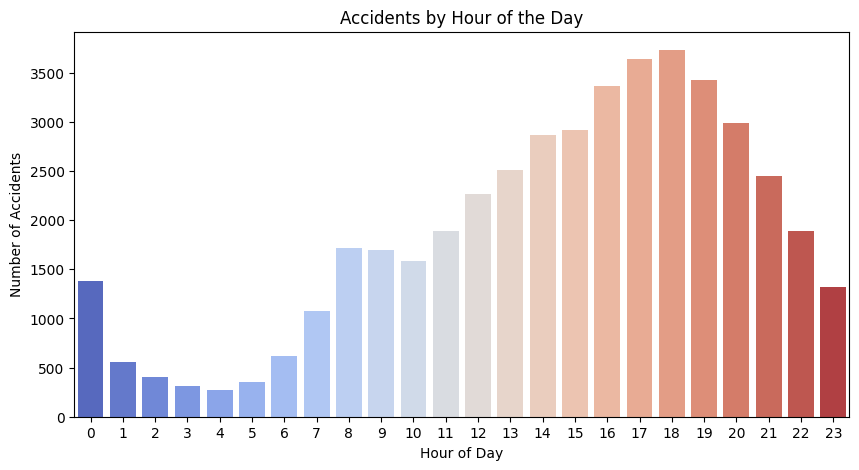

In [23]:
# Time-Based Patterns: Accidents by Hour and Day ---
import seaborn as sns
# Convert CRASH DATE to datetime format and extract hour & day
nypd_accidents["CRASH DATE"] = pd.to_datetime(nypd_accidents["CRASH DATE"])
nypd_accidents["CRASH HOUR"] = pd.to_datetime(nypd_accidents["CRASH TIME"], format="%H:%M").dt.hour
nypd_accidents["CRASH DAY"] = nypd_accidents["CRASH DATE"].dt.day_name()

# Plot accidents per hour
plt.figure(figsize=(10, 5))
sns.countplot(data=nypd_accidents, x="CRASH HOUR", palette="coolwarm")
plt.title("Accidents by Hour of the Day")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Accidents")
plt.show()


/var/folders/tw/yc01l_99601d14ks8nxwg1dr0000gn/T/ipykernel_89665/2648732014.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=nypd_accidents, x="CRASH DAY", order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], palette="magma")


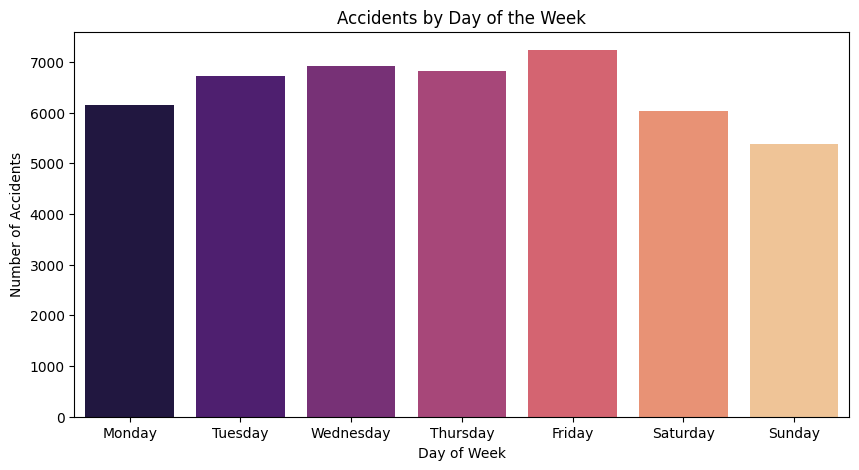

In [24]:
# Plot accidents per day
plt.figure(figsize=(10, 5))
sns.countplot(data=nypd_accidents, x="CRASH DAY", order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], palette="magma")
plt.title("Accidents by Day of the Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Accidents")
plt.show()


/var/folders/tw/yc01l_99601d14ks8nxwg1dr0000gn/T/ipykernel_89665/2694835904.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=high_risk_intersections.values, y=high_risk_intersections.index, palette="rocket")


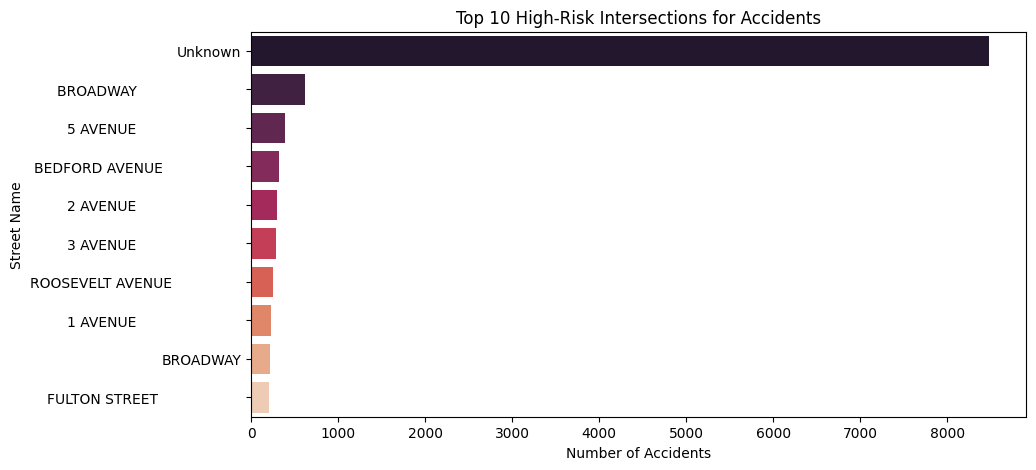

In [25]:
# Road Conditions: High-Risk Intersections ---

# Assume ON STREET NAME column exists
high_risk_intersections = nypd_accidents["ON STREET NAME"].value_counts().head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=high_risk_intersections.values, y=high_risk_intersections.index, palette="rocket")
plt.title("Top 10 High-Risk Intersections for Accidents")
plt.xlabel("Number of Accidents")
plt.ylabel("Street Name")
plt.show()


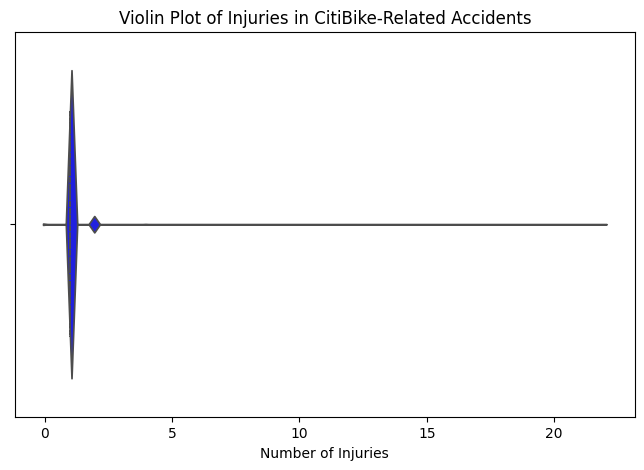

In [33]:
# Severity Analysis: Injuries/Fatalities near CitiBike Stations ---

# Filter severe accidents near CitiBike stations
severe_accidents = nypd_accidents[
    (nypd_accidents["NUMBER OF PERSONS INJURED"] > 0) | 
    (nypd_accidents["NUMBER OF PERSONS KILLED"] > 0)
]

# Violin plot to show injury distribution with density
plt.figure(figsize=(8, 5))
sns.violinplot(x=severe_accidents["NUMBER OF PERSONS INJURED"], color="blue", inner="quartile")
plt.title("Violin Plot of Injuries in CitiBike-Related Accidents")
plt.xlabel("Number of Injuries")
plt.show()


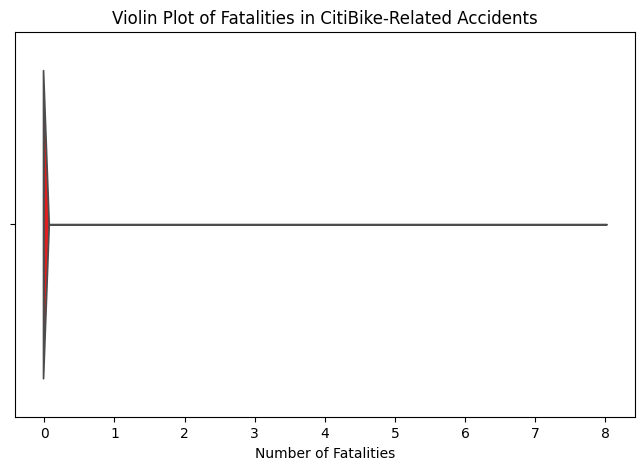

In [34]:
# Violin plot for fatalities in CitiBike-related accidents
plt.figure(figsize=(8, 5))
sns.violinplot(x=severe_accidents["NUMBER OF PERSONS KILLED"], color="red", inner="quartile")
plt.title("Violin Plot of Fatalities in CitiBike-Related Accidents")
plt.xlabel("Number of Fatalities")
plt.show()
